# Classification and regression

Linear regression, covered in the previous chapter, is often seen as an
entry method to enter the world of supervised machine learning. However,
not every phenomenon can be explained using a linear relationship, and
not everything is a regression. For the former, you need to use methods
that have a bit more complicated math behind them (but often the same
Python API). For the latter, you will often need to look for
classification models. Both of these options are covered in this
chapter, which will outline methods of introducing spatial dimension to
commonly used machine learning models. To a degree, it is a continuation
of the work covered last time, but there are some new things here and
there.

> **This is not an introduction to ML**
>
> Note that this material does not aim to cover an introduction to
> machine learning thoroughly. There are other, much better materials
> for that. One of them can be [scikit-learn’s User
> guide](https://scikit-learn.org/stable/user_guide.html), but I am sure
> you will find one that suits you.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from sklearn import ensemble, metrics, model_selection

## Data

The data you will work with today comes from the study on the urban
development of Prague, published in @fleischmann2022Methodological. The
original dataset is significantly simplified for the purpose of this
material and contains point data reflecting the location of buildings in
Prague with a subset of measured attributes describing each one and
(aggregated) type of urban development they belong to. The type is a
categorical variable that will be your dependent variable today. The
goal is to use the other variables and spatial information to predict
which type each building belongs to.

> **Caution**
>
> The dataset contains ~140k points, so I don’t recommend using
> `explore()` on all of it.

In [2]:
building_data = gpd.read_file("data/prg_building_locations.gpkg", engine="pyogrio")
building_data.head()

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/chapter_11/data/prg_building_locations.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> building_data = gpd.read_file(
>     "prg_building_locations.gpkg",
> )
> ```

The original taxonomy has been re-classified to provide eight types of
urban development shown in the figure below.

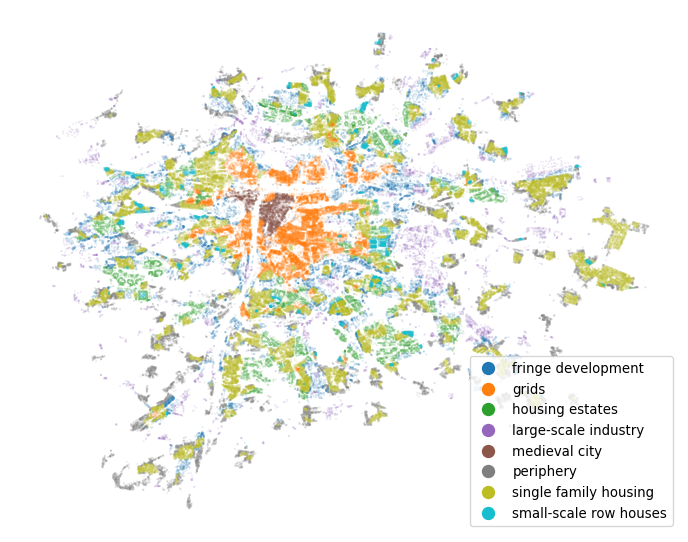

In [3]:
ax = building_data.plot(
    "cluster", legend=True, figsize=(9, 9), markersize=0.005
)
ax.set_axis_off()


List the columns containing some numerical value and save it as a
variable. There are six of them out of the original few hundred.

In [4]:
independent_variables = [
    "floor_area_ratio",
    "height",
    "compactness",
    "street_alignment",
    "interbuilding_distance",
    "block_perimeter_wall_length",
]

It may be helpful to understand the spatial distribution of each of them
to know what to expect, and build an intuition about their relationship
with the classification above.

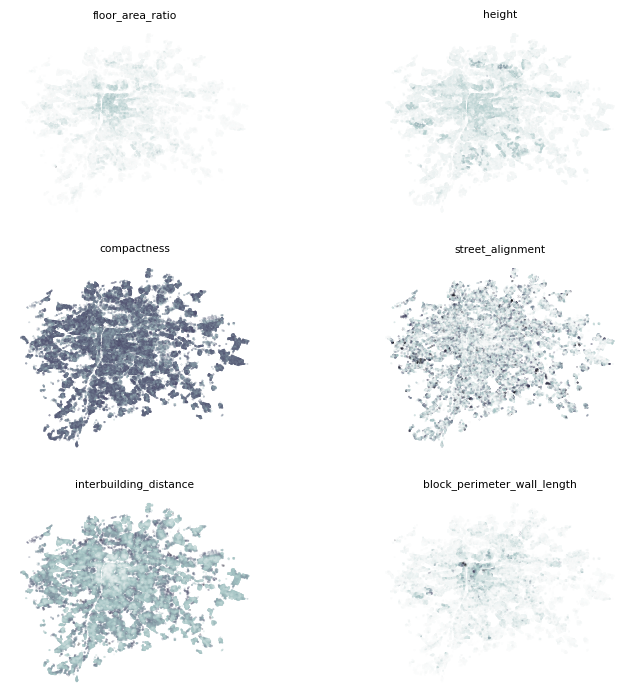

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(9, 9))
axs = axs.flatten()
for i, var in enumerate(independent_variables):
    building_data.plot(var, markersize=0.01, cmap="bone_r", ax=axs[i])
    axs[i].set_title(var, fontdict={"fontsize": 8})
    axs[i].set_axis_off()

## Classification 101

The main task of today is to train classification models using the
`scikit-learn`, so let’s begin.

### Data preparation

The dataset contains a bit over 140k points. While more data tend to
bring additional performance to ML models, the relationship is far from
linear, and you often get nearly as performant models using just a
fraction of data. Moreover, it takes longer to train on more data :).

Select a random sample of 20k points you will work with. You can later
test for yourself how big of an effect the size of the sample has.

In [6]:
training_sample = building_data.sample(20_000, random_state=0)


From the sample, extract the `DataFrame` with just the independent
variables for the simplicity.

In [7]:
independent = training_sample[independent_variables]
independent.head(2)

### Train-test split

Some data are used to train the model, but the same data cannot be used
for evaluation. The models tend to learn those exact values, and the
performance metrics derived from training data show a much higher score
than the model can on unseen data. One way around this is to split the
dataset into two parts - `train` and `test`. The `train` part is used to
train the model. However, the `test` part is left out of training and is
later used to evaluate performance without worrying that any of the data
points were seen by the model before.

`scikit-learn` offers handy function to split the data into train and
test parts, dealing with both dependent and independent variables at the
same time.

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    independent, training_sample["cluster"], test_size=0.25, random_state=0
)


### Random Forest Classifier

While there is a large number of ML models available, your goal today is
not to understand which ML model is better and how to fine-tune it but
how to include the spatial dimension in them. So, let’s not complicate
the situation and stick to one of the common models - [random
forest](https://en.wikipedia.org/wiki/Random_forest).

Random forest classifier is implemented within the `ensemble` module of
the `scikit-learn` and has the API you should already be familiar with.
Get the training data and fit the baseline model without thinking about
space and geography at all.

In [9]:
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

#### Prediction

The trained model can be directly used to predict the classes (type of
development in this case). Using the test portion of data, you can get
the predicted label:

In [10]:
pred = model.predict(X_test)
pred

array(['single family housing', 'single family housing', 'medieval city',
       ..., 'single family housing', 'grids', 'single family housing'],
      dtype=object)

Or probabilities for every single class. The class prediction above just
involves selecting the one with the maximum probability.

In [11]:
proba = model.predict_proba(X_test)
proba

array([[0.02, 0.18, 0.06, ..., 0.04, 0.42, 0.25],
       [0.01, 0.  , 0.  , ..., 0.13, 0.86, 0.  ],
       [0.  , 0.2 , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.03, 0.09, 0.  , ..., 0.07, 0.49, 0.32],
       [0.  , 0.99, 0.  , ..., 0.  , 0.  , 0.01],
       [0.07, 0.18, 0.04, ..., 0.  , 0.52, 0.09]])

Both outputs are numpy arrays, but the probabilities would be especially
helpful to see as a `DataFrame` with column names representing class
names. Those are available as `.classes_`:

In [12]:
model.classes_

array(['fringe development', 'grids', 'housing estates',
       'large-scale industry', 'medieval city', 'periphery',
       'single family housing', 'small-scale row houses'], dtype=object)

You can quickly combine it all with the original index to get a
`DataFrame` of probabilities.

In [13]:
pd.DataFrame(proba, columns=model.classes_, index=X_test.index)

5000 rows × 8 columns

#### Evaluation

Now comes the evaluation part. Normally, you are interested in a number
of performance metrics capturing how good the model is. Among the most
common ones are *accuracy* and *Cohen’s kappa score*. Accuracy captures
the fraction of correct predictions, i.e., how many labels in the
predicted array equal the known labels. [Kappa
score](https://en.wikipedia.org/wiki/Cohen%27s_kappa) It is seen as a
more robust metric but not straightforwardly interpretable.

In [14]:
accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)


Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45


The results are not bad, considering the limited amount of information
provided in independent variables. Around 58% of labels are correctly
predicted.

Apart from the model performance, you can also evaluate how important
each of the independent variables for the result is using the
`.feature_importances_` metric. Again, wrapping it in a pandas object is
useful to get feature names alongside the values.

In [15]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values()

compactness                    0.125213
street_alignment               0.125471
floor_area_ratio               0.166246
height                         0.174648
block_perimeter_wall_length    0.187244
interbuilding_distance         0.221179
dtype: float64

There seems to be a relatively good balance of importance ranging from
12% for compactness to 22% for inter-building distance. Check if that
matches our intuition in relation to the spatial distribution of each of
them.

### Cross-validated prediction

Now, if you want to plot the predicted labels on a map, you can do that
reliably only for the test sample. The training sample was seen by the
model and would not be representative of model capabilities.
Nevertheless, you can create a map using the complete sample, just not
using exactly the same model for all its parts. Welcome cross-validated
prediction.

Cross-validated (CV) prediction splits the dataset (before you divided
it into train and test) into a small number of parts and trains a
separate model to predict labels for each of them. In the example below,
it creates four equally-sized parts and then takes three of them as
*train* part to train a model that is used to predict labels on the
fourth one. Then, it switches the one that is left out and repeats the
process until there are labels for every part. The resulting labels
should not contain any data leakage between train and test samples.
However, as described below, that is not always the case when dealing
with spatial data.

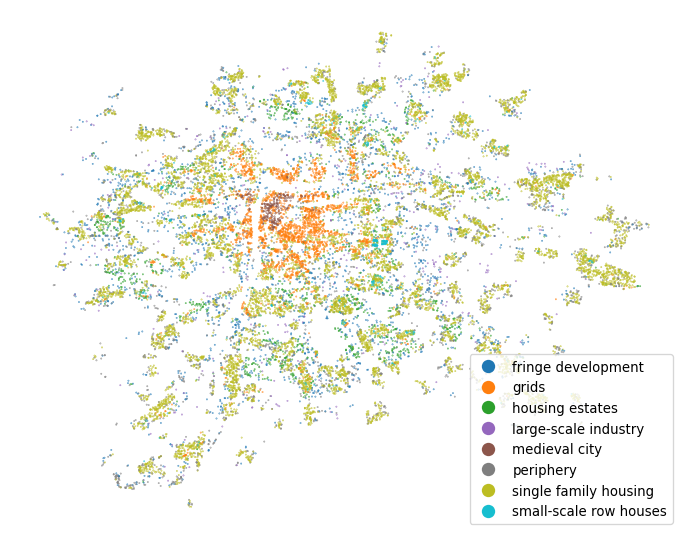

In [16]:
predicted = model_selection.cross_val_predict(
    model, independent, training_sample["cluster"], cv=4, n_jobs=-1
)

ax = training_sample.plot(predicted, legend=True, figsize=(9, 9), markersize=0.1)
ax.set_axis_off()

What CV-prediction allows to not only plot the labels but importantly to
plot the spatial pattern of errors.

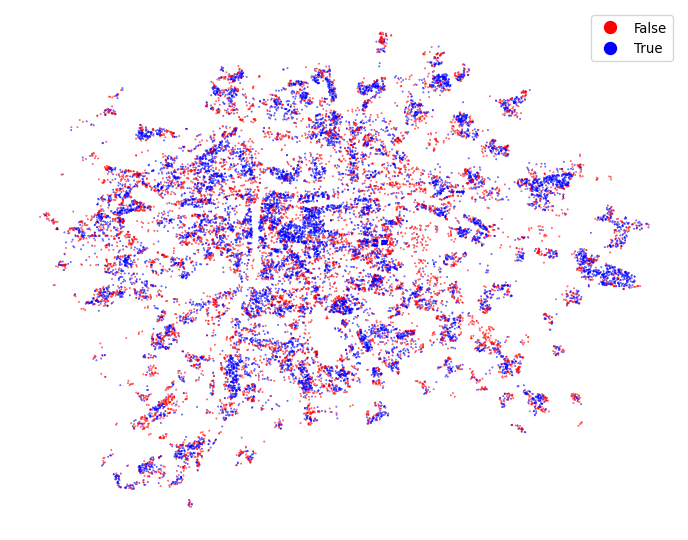

In [17]:
ax = training_sample.plot(
    predicted == training_sample["cluster"],
    categorical=True,
    figsize=(9, 9),
    markersize=0.1,
    cmap="bwr_r",
    legend=True,
)
ax.set_axis_off()

As with the linear regression, a spatial autocorrelation of errors means
that the model does not represent space reliably and may need some
adaptations.

## Spatial cross-validation

When dividing the data into *train* and *test* parts, you are trying to
eliminate data leakage, which happens when information from one set
makes its way to the other. The evaluation affected by leakage then
indicates better results than the reality is. This works well for most
of data, but not so much for spatial data. Tobler’s first law of
geography, which says that nearby things are similar, breaks the
assumption of no leakage. Two points that are right next to each other
in space, one randomly allocated to the *train* part and the other to
the *test* part, are not statistically independent. You can assume that
they will be similar, and this similarity caused by the spatial
proximity comes with a potential data leakage.

Spatial CV mitigates the issue by including a spatial dimension in the
train-test split. The aim is to divide the whole study area into smaller
regions and allocate whole regions to train and test splits. You can do
that based on many criteria, but it is handy to have a variable
representing those regions as the `"basic_settlement_unit"` column in
your DataFrame.

With a categorical column indicating groups, you can use the
`StratifiedGroupKFold` class from the `scikit-learn` to create the
folds.

In [18]:
gkf = model_selection.StratifiedGroupKFold(n_splits=5)
splits = gkf.split(
    training_sample,
    training_sample.cluster,
    groups=training_sample.basic_settlement_unit,
)


The `splits` variable now contains an iterator - an object we can loop
through that gives you train and test parts for each split. You can
easily extract the labels indicating the splits:

In [19]:
split_label = np.empty(len(training_sample), dtype=float)
for i, (train, test) in enumerate(splits):
    split_label[test] = i
training_sample["split"] = split_label


With the labels extracted from `StratifiedGroupKFold`, you can plot the
splits on a map.

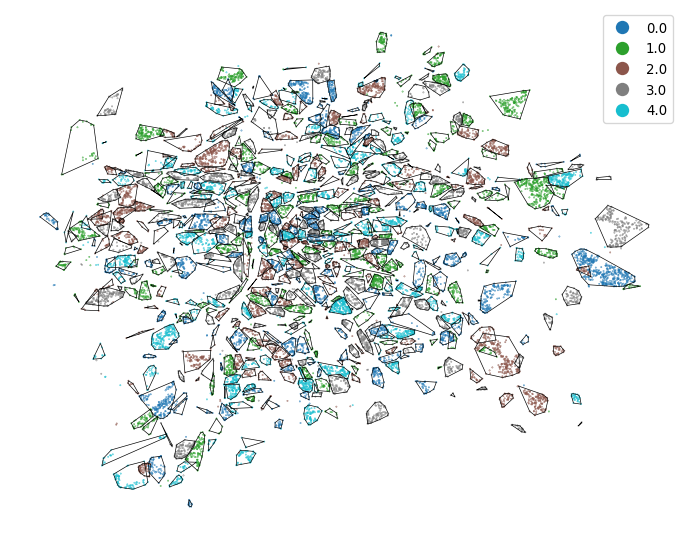

In [20]:
ax = training_sample.plot(
  "split", categorical=True, figsize=(9, 9), markersize=0.1, legend=True
)
training_sample.dissolve("basic_settlement_unit").convex_hull.boundary.plot(
    ax=ax, color="k", linewidth=0.5, markersize=0
)
ax.set_axis_off()


With the new, and arguably better train-test, split, you can create new
training and evaluation data. You can use the split with the label `0`
as a test part and the rest as a train part.

In [21]:
train = training_sample["split"] != 0
X_train = independent.loc[train]
y_train = training_sample["cluster"].loc[train]

test = training_sample["split"] == 0
X_test = independent.loc[test]
y_test = training_sample["cluster"].loc[test]

New data require a new model.

In [22]:
rf_spatial_cv = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_spatial_cv.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

And its evaluation. Just use `+=` to add to the existing summary.

In [23]:
pred = rf_spatial_cv.predict(X_test)

accuracy_spatial_cv = metrics.accuracy_score(pred, y_test)
kappa_spatial_cv = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Basic model with spatial cross-validation:
  Accuracy: {round(accuracy_spatial_cv, 3)}
  Kappa:    {round(kappa_spatial_cv, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419


The results are marginally worse, but that is expected. It means that
the original model was indeed a bit leaking! The model based on the
spatial CV should be more robust than the previous one, meaning that it
should perform as expected on unseen data.

The result is worse on paper but is now more spatially robust - it will
generalize better on unseen data.

## Feature engineering

Sometimes, the original data is just not enough for a decent prediction.
At that point, you may want to include some other variables that would
help, but they may not be readily available, and you need to create
them.

The first option is to look at the data you have and extract some
additional information from it using methods known as map synthesis.

### Map synthesis

Map synthesis uses the spatial structure of the data to derive new
features. There’s no external input, you simply put geography at work.

#### Point density

There are methods of map synthesis that work directly with existing
values, and there are those that look solely at the spatial distribution
of your data. One example of the latter is a measurement of point
density (number of neighbors within a distance band).

You should already know how to do that using the `graph` module of
`libpysal`. Create a `Graph` and extract its cardinalities (the number
of neighbors).

In [24]:
distance_200 = graph.Graph.build_distance_band(training_sample, 200)
training_sample["points_in_200m"] = distance_200.cardinalities

Let’s check if the result has some meaningful spatial pattern.

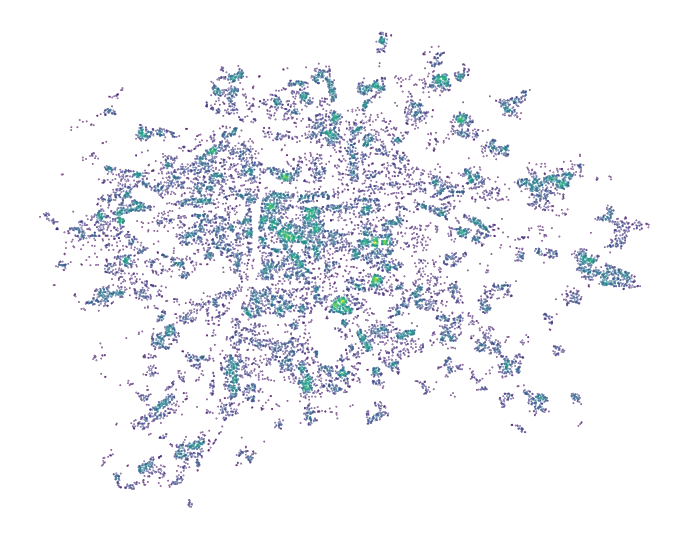

In [25]:
ax = training_sample.plot("points_in_200m", figsize=(9, 9), markersize=0.1)
ax.set_axis_off()

It is not a strong one, but there are clear pockets of the higher point
density, so this new column can help with the prediction accuracy.
Create a new set of independent variables, including the new one, and
generate new training and evaluation data.

In [26]:
independent_proximity = training_sample[
    independent_variables + ["points_in_200m"]
]

X_train = independent_proximity.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_proximity.loc[test]
y_test = training_sample["cluster"].loc[test]


The rest is simply rinse and repeat. Create the model and train it on
new data.

In [27]:
rf_proximity = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_proximity.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

And evaluate it in the same way as before.

In [28]:
pred = rf_proximity.predict(X_test)

accuracy_proximity = metrics.accuracy_score(pred, y_test)
kappa_proximity = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Points within 200m (spatial CV):
  Accuracy: {round(accuracy_proximity, 3)}
  Kappa:    {round(kappa_proximity, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46


Remember that your baseline model is the *Basic model with spatial
cross-validation*. Compared to that, the performance of the new model is
a bit better, especially when looking at Cohen’s kappa. It seems that
the point density brings some value. You can check how important it is
compared to the original variables.

In [29]:
pd.Series(
    rf_proximity.feature_importances_, index=rf_proximity.feature_names_in_
).sort_values()

compactness                    0.108827
street_alignment               0.109489
points_in_200m                 0.126702
floor_area_ratio               0.146121
height                         0.159027
block_perimeter_wall_length    0.173754
interbuilding_distance         0.176080
dtype: float64

It seems that not that much, but each percent of accuracy counts.

Point density is just one example, and there are many more. Below, when
dealing with spatial dependence, you’ll get back to map synthesis once
again. But before that, let’s use some external data to improve the
model.

### Proximity variables

Sometimes, you may have an assumption that a distance to a specific
location or a set of locations makes a difference to the spatial
distribution of the dependent variable, and the inclusion of a variable
reflecting this distance could help the model. You can think of distance
to subway stations when dealing with rent price prediction or distance
to highways when trying to predict air pollution. In the case of urban
development in Prague, it may be interesting to capture the distance
from the city centre. Prague is a very monocentric city whose
development happened over the years in a series of concentric rings.
First, the medieval centre, then industrial-era neighborhoods behind the
original city walls, and so on. Therefore, a distance to Old Town Square
may be useful for the development type prediction.

You have done this
[before](../chapter_03/hands_on.html#measuring-distance), so fire up
geocoding, and extract the point representing the square in the same CRS
the rest of the data is in.

``` py
old_town_square = (
    gpd.tools.geocode("Old Town Square, Prague")
    .to_crs(building_data.crs)
    .geometry.item()
)
```

With the point, you can measure the distance from every building in the
training sample and use the resulting column as another independent
variable.

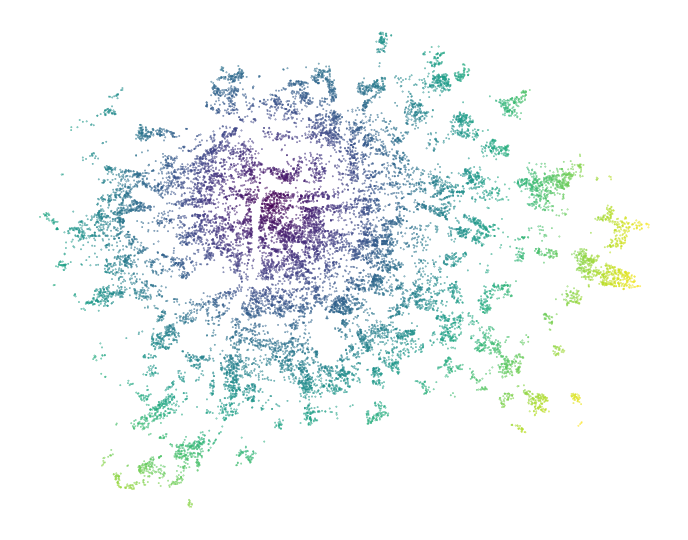

In [31]:
training_sample["distance_to_old_town"] = training_sample.distance(old_town_square)

ax = training_sample.plot("distance_to_old_town", figsize=(9, 9), markersize=0.1)
ax.set_axis_off()

Now simply add it to the `DataFrame` representing independent variables
and the rest is the same.

In [32]:
independent_distance = training_sample[
    independent_variables + ["points_in_200m", "distance_to_old_town"]
]

X_train = independent_distance.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_distance.loc[test]
y_test = training_sample["cluster"].loc[test]

Get a new, hopefully better model.

In [33]:
rf_distance = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_distance.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

And check if the new variable makes a difference.

In [34]:
pred = rf_distance.predict(X_test)

accuracy_distance = metrics.accuracy_score(pred, y_test)
kappa_distance = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Distance to Old Town Sq + above (spatial CV):
  Accuracy: {round(accuracy_distance, 3)}
  Kappa:    {round(kappa_distance, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532


That is quite a decent bump in performance! It seems that the distance
to the city centre is not bad in explaining the development typology.
Check how important it is within the model.

In [35]:
pd.Series(
    rf_distance.feature_importances_, index=rf_distance.feature_names_in_
).sort_values()

compactness                    0.083833
street_alignment               0.084431
points_in_200m                 0.114884
floor_area_ratio               0.118693
height                         0.121907
block_perimeter_wall_length    0.136004
interbuilding_distance         0.143222
distance_to_old_town           0.197027
dtype: float64

Interestingly enough, it seems to be more explanatory than any of the
variables reflecting the actual morphology.

### Map matching

In other cases, you can make use of other data and link it to existing
data. When you join the data based on spatial operation, you can talk
about map matching. You can measure a number of points of interest in
the vicinity of each location, [link the data from
rasters](../chapter_08/hands_on.html#extracting-values-for-locations-with-xvec),
[interpolate them from point
patterns](../chapter_09/hands_on.html#point-interpolation) or [from
polygons to other
polygons](../chapter_09/hands_on.html#areal-interpolation-and-dasymetric-mapping).
By now, you should know all that, so there’s no need to go into detail.
Sticking to a simple case, map matching can also be done using a spatial
join.

Load the price data you worked with in the Learning GeoPandas chapter.

In [36]:
price = gpd.read_file(
    "https://martinfleischmann.net/sds/chapter_03/data/SED_CenovaMapa_p_shp.zip",
)
price["CENA"] = price["CENA"].replace("N", None).astype("float")
price.head(2)


Before any spatial joins, check the CRS.

In [37]:
price.crs.equals(training_sample.crs)

False

And, like in this case, don’t forget to re-project geometries in case of
a CRS mismatch. Then you can go ahead with the spatial join.

In [38]:
price = price.to_crs(training_sample.crs)

training_sample_price = training_sample.sjoin(
    price[["CENA", "geometry"]].dropna()
)
training_sample_price.head(2)


You can prepare data for a model with price included.

In [39]:
independent_proximity_price = training_sample_price[
    independent_variables + ["points_in_200m", "distance_to_old_town", "CENA"]
]

train_price = training_sample_price["split"] != 0
X_train = independent_proximity_price.loc[train_price]
y_train = training_sample_price["cluster"].loc[train_price]

test_price = training_sample_price["split"] == 0
X_test = independent_proximity_price.loc[test_price]
y_test = training_sample_price["cluster"].loc[test_price]


The rest, you know. First the model.

In [40]:
rf_distance_price = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_distance_price.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

Then, the evaluation.

In [41]:
pred = rf_distance_price.predict(X_test)

accuracy_distance_price = metrics.accuracy_score(pred, y_test)
kappa_distance_price = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Price + above (spatial CV):
  Accuracy: {round(accuracy_distance_price, 3)}
  Kappa:    {round(kappa_distance_price, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532
Price + above (spatial CV):
  Accuracy: 0.684
  Kappa:    0.568


Another improvement. It seems that price is not that critical, but is
surely brings some value.

In [42]:
pd.Series(
    rf_distance_price.feature_importances_, index=rf_distance_price.feature_names_in_
).sort_values()

compactness                    0.065091
street_alignment               0.066118
floor_area_ratio               0.087641
points_in_200m                 0.102291
height                         0.112258
interbuilding_distance         0.119136
block_perimeter_wall_length    0.136948
CENA                           0.137774
distance_to_old_town           0.172743
dtype: float64

As the feature importance shows, it is among the most important
variables, though the distance to the Old Town Sq. is still unbeaten.

## Spatial dependence

Let’s get back to map synthesis and talk about spatial dependence. Some
phenomena, urban development type may be one of them, are not explained
only by values linked to individual geometries but also by the spatial
configuration of the observations around. If the mean inter-building
distance of observation A is small but that of nearly all observations
around is high, it may be worth taking that into account. You can say
that the predicted value on observation A *depends* on the spatial
context and configuration around it. Generally speaking, the values of
observations are related to each other based on their distance and are
spatially dependent, reflecting Tobler’s First law of geography once
again.

### Include spatially lagged variables in the model

The simplest way of incorporating spatial dependence to a generic ML
model is to add variables to your set of independent variables capturing
spatial dependence through spatial lag.

Use the spatial weights matrix created above and generate a spatial lag
of all independent variables.

In [43]:
distance_200_row = distance_200.transform("r")
lagged_variables = []
for var in independent_variables:
    training_sample[f"{var}_lag"] = distance_200_row.lag(training_sample[var])
    lagged_variables.append(f"{var}_lag")
training_sample.head(2)


It may be interesting to assess the effect of spatial dependence without
the variables added above. Combine original independent variables with
the new lagged and prepare new training data.

In [44]:
independent_lag = training_sample[independent_variables + lagged_variables]

X_train = independent_lag.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_lag.loc[test]
y_test = training_sample["cluster"].loc[test]

Fit the new model, which should be able to use spatial dependence.

In [45]:
rf_lag_200m = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_lag_200m.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

And check how significant an effect it has on the model performance.

In [46]:
pred = rf_lag_200m.predict(X_test)

accuracy_lag = metrics.accuracy_score(pred, y_test)
kappa_lag = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Spatial dependence - lagged model (spatial CV):
  Accuracy: {round(accuracy_lag, 3)}
  Kappa:    {round(kappa_lag, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532
Price + above (spatial CV):
  Accuracy: 0.684
  Kappa:    0.568
Spatial dependence - lagged model (spatial CV):
  Accuracy: 0.678
  Kappa:    0.573


That is surely not negligible, considering that no other data were
needed.

In [47]:
pd.Series(
    rf_lag_200m.feature_importances_, index=rf_lag_200m.feature_names_in_
).sort_values()

compactness                        0.043229
street_alignment                   0.046029
height                             0.057588
floor_area_ratio                   0.058145
block_perimeter_wall_length        0.067363
street_alignment_lag               0.070991
compactness_lag                    0.075911
height_lag                         0.102984
interbuilding_distance             0.103224
interbuilding_distance_lag         0.114796
block_perimeter_wall_length_lag    0.126160
floor_area_ratio_lag               0.133580
dtype: float64

The feature importance very clearly shows that when detecting urban
typology, the context is always more important than the individual
observation. It is expected as the typology attempts to reflect the
general pattern of development but you can see the similar effect in
many other situations.

## Spatial heterogneity

While ML models like the random forest learn interaction between
variables, they are not always able to pick up spatial heterogeneity of
the interaction between dependent and independent variables. Last week,
you tried to deal with spatial heterogeneity using the categorical
variable reflecting the spatial fixed effect. You could do the same
here, but let’s try another approach.

### Include x, y coordinates

Including the x and y (or longitude and latitude) coordinates of your
geometries is a clever way of capturing the spatial heterogeneity in the
model. The location serves as a proxy for any unexplained variance of a
spatial nature. It does not help you with interpretation, as coordinates
do not explain anything.

The model will also struggle to generalise outside of the original
spatial extent. So while a model trained on Prague using the original
set of variables could be easily used in any other Czech city, like
Brno, the model that includes coordinates would have no idea how to
interpret the values it would see in Brno. Use with caution.

Technically, it is dead simple. You just include coordinates as another
two columns.

In [48]:
training_sample[["x", "y"]] = training_sample.get_coordinates()
training_sample.head(2)

2 rows × 21 columns

To check the effect of spatial heterogeneity compared to the baseline
model, create new training data with the original variables and
coordinates on top.

In [49]:
independent_coordinates = training_sample[independent_variables + ["x", "y"]]

X_train = independent_coordinates.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_coordinates.loc[test]
y_test = training_sample["cluster"].loc[test]

Train the model.

In [50]:
rf_coordinates = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_coordinates.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

And evaluate its performance.

In [51]:
pred = rf_coordinates.predict(X_test)

accuracy_coordinates = metrics.accuracy_score(pred, y_test)
kappa_coordinates = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Spatial heterogeneity - coordinates (spatial CV):
  Accuracy: {round(accuracy_coordinates, 3)}
  Kappa:    {round(kappa_coordinates, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532
Price + above (spatial CV):
  Accuracy: 0.684
  Kappa:    0.568
Spatial dependence - lagged model (spatial CV):
  Accuracy: 0.678
  Kappa:    0.573
Spatial heterogeneity - coordinates (spatial CV):
  Accuracy: 0.632
  Kappa:    0.501


There indeed is some degree of spatial heterogeneity, but its effect is
not that strong as that of spatial dependence.

In [52]:
pd.Series(
    rf_coordinates.feature_importances_, index=rf_coordinates.feature_names_in_
).sort_values()

compactness                    0.079772
street_alignment               0.082567
height                         0.120324
floor_area_ratio               0.121949
block_perimeter_wall_length    0.140227
x                              0.141132
y                              0.144687
interbuilding_distance         0.169343
dtype: float64

Interpreting feature importance is a bit more complicated, as x and y
are not to be treated as two separate variables but as a pair. You can
try to sum their importance, but remember that the result may be
misleading.

## Heterogeneity and dependence

You can try to combine the effects of heterogeneity and dependence
within a single model as each seems to help when used separately.

In [53]:
independent_coordinates = training_sample[
    independent_variables + lagged_variables + ["x", "y"]
]

X_train = independent_coordinates.loc[train]
y_train = training_sample["cluster"].loc[train]

X_test = independent_coordinates.loc[test]
y_test = training_sample["cluster"].loc[test]

Let’s consider this a final model of the day.

In [54]:
rf_het_dep = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
rf_het_dep.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_jobs=-1, random_state=0)

The final evaluation:

In [55]:
pred = rf_het_dep.predict(X_test)

accuracy_het_dep = metrics.accuracy_score(pred, y_test)
kappa_het_dep = metrics.cohen_kappa_score(pred, y_test)

summary += f"""\
Spatial dependence + heterogeneity (spatial CV):
  Accuracy: {round(accuracy_het_dep, 3)}
  Kappa:    {round(kappa_het_dep, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532
Price + above (spatial CV):
  Accuracy: 0.684
  Kappa:    0.568
Spatial dependence - lagged model (spatial CV):
  Accuracy: 0.678
  Kappa:    0.573
Spatial heterogeneity - coordinates (spatial CV):
  Accuracy: 0.632
  Kappa:    0.501
Spatial dependence + heterogeneity (spatial CV):
  Accuracy: 0.711
  Kappa:    0.615


This seems to be the best model so far. Keep in mind that variables
coming from the feature engineering section are not included here, so
there still may be some space for an improvement.

In [56]:
pd.Series(
    rf_het_dep.feature_importances_, index=rf_het_dep.feature_names_in_
).sort_values()

compactness                        0.032525
street_alignment                   0.036007
floor_area_ratio                   0.047823
height                             0.049390
street_alignment_lag               0.057048
block_perimeter_wall_length        0.057807
compactness_lag                    0.063732
y                                  0.068235
x                                  0.071409
height_lag                         0.083217
interbuilding_distance             0.090460
interbuilding_distance_lag         0.102752
block_perimeter_wall_length_lag    0.117814
floor_area_ratio_lag               0.121782
dtype: float64

Both lagged variables and coordinates are valuable here but keep in mind
that the strength of these effects will vary dependning on specific use
case. What is clearly useful in this case may have no value in other
situations.

### Prediction on the whole dataset

If you consider `rf_het_dep` a final model you are happy with, you can
check how it performs on the full dataset, not only on the sample of 20k
observations used above.

First, you will need all the variables computed for the full dataset.

In [57]:
distance_200_all = graph.Graph.build_distance_band(building_data, 200).transform("r")
for var in independent_variables:
    building_data[f"{var}_lag"] = distance_200_all.lag(building_data[var])

building_data[["x", "y"]] = building_data.get_coordinates()

Then, you can use the model for inference. First, check the
probabilities.

In [58]:
probabilities = rf_het_dep.predict_proba(
    building_data[independent_variables + lagged_variables + ["x", "y"]]
)
probabilities

array([[0.29, 0.05, 0.42, ..., 0.  , 0.05, 0.  ],
       [0.  , 0.04, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.1 , 0.  , 0.  , ..., 0.49, 0.41, 0.  ],
       ...,
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.52, 0.06, 0.01, ..., 0.1 , 0.07, 0.01]])

Plotting class-based probabilities allows you to visualise the
likelihood that each observation (building in our case) belonging to
each class.

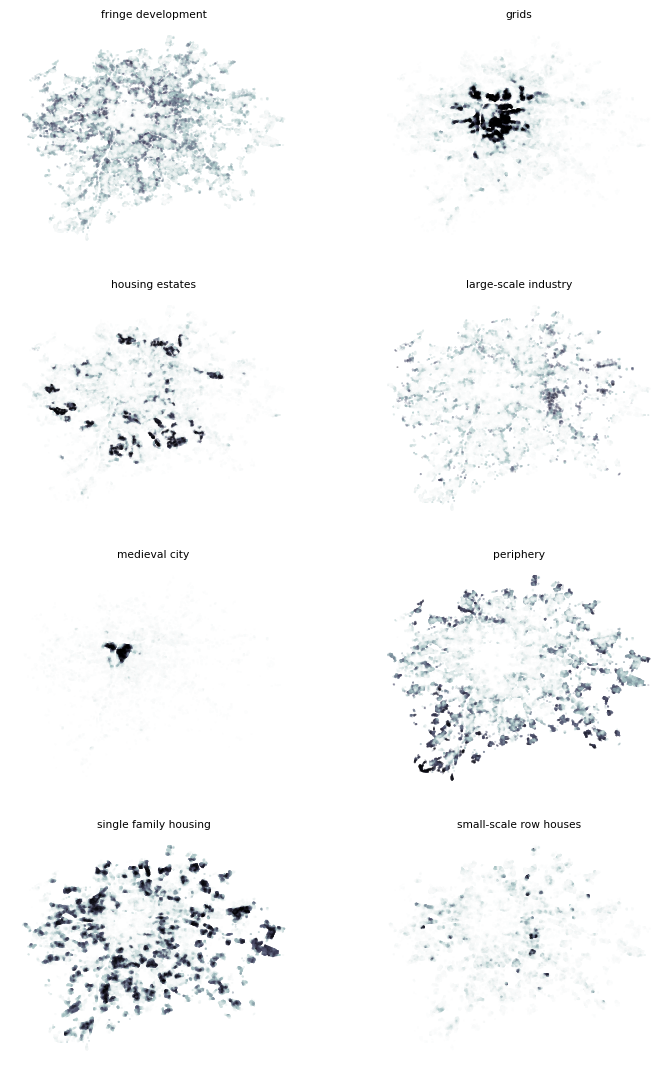

In [59]:
fig, axs = plt.subplots(4, 2, figsize=(9, 14))
axs = axs.flatten()
for i, ax in enumerate(axs):
    building_data.plot(
      probabilities[:, i], markersize=0.01, cmap="bone_r", ax=ax, vmin=0, vmax=1,
    )
    axs[i].set_title(rf_het_dep.classes_[i], fontdict={"fontsize": 8})
    ax.set_axis_off()

Plotting the maximum probability assigned to an observation regardless
of class is also useful. This can be seen as a proxy of the certainty of
a model and allows you to identify areas where the model works well and
has no issue picking up the correct class and those where it struggles.

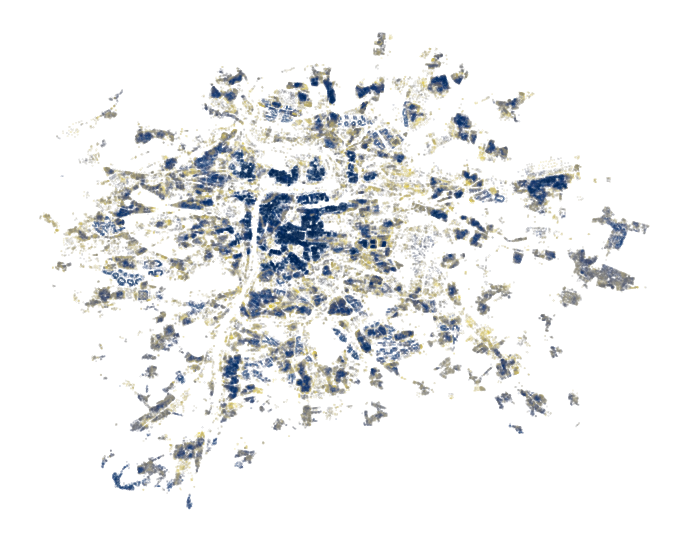

In [60]:
building_data.plot(
    probabilities.max(axis=1), markersize=0.01, cmap="cividis_r", figsize=(9, 9)
).set_axis_off()

If you want just a label, it is easier to use the `predict()` method
instead.

In [61]:
predicted_class = rf_het_dep.predict(
    building_data[independent_variables + lagged_variables + ["x", "y"]]
)

The predicted labels allow you to check the spatial pattern of errors as
you did earlier.

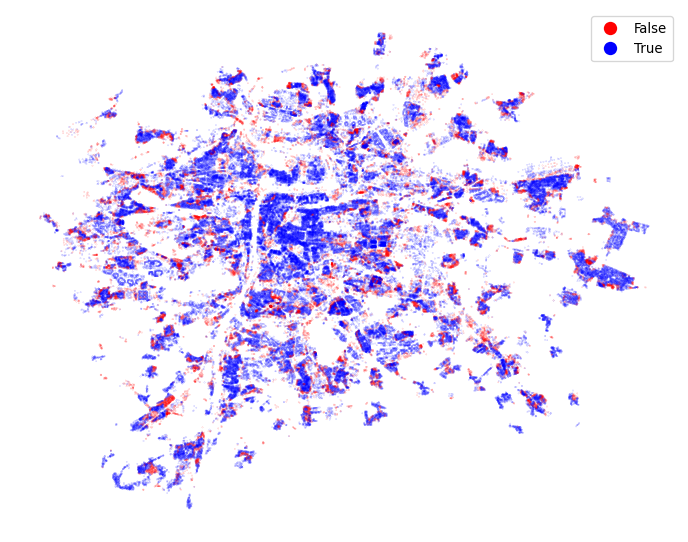

In [62]:
building_data.plot(
    predicted_class == building_data["cluster"],
    categorical=True,
    figsize=(9, 9),
    markersize=0.005,
    cmap="bwr_r",
    legend=True,
).set_axis_off()

Finally, you may be interested in the performance of the model on the
full dataset.

In [63]:
accuracy_all = metrics.accuracy_score(predicted_class, building_data["cluster"])
kappa_all = metrics.cohen_kappa_score(predicted_class, building_data["cluster"])

summary += f"""
Complete dataset
----------------
Spatial dependence + heterogeneity (spatial CV):
  Accuracy: {round(accuracy_all, 3)}
  Kappa:    {round(kappa_all, 3)}
"""
print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.585
  Kappa:    0.45
Basic model with spatial cross-validation:
  Accuracy: 0.57
  Kappa:    0.419
Points within 200m (spatial CV):
  Accuracy: 0.598
  Kappa:    0.46
Distance to Old Town Sq + above (spatial CV):
  Accuracy: 0.651
  Kappa:    0.532
Price + above (spatial CV):
  Accuracy: 0.684
  Kappa:    0.568
Spatial dependence - lagged model (spatial CV):
  Accuracy: 0.678
  Kappa:    0.573
Spatial heterogeneity - coordinates (spatial CV):
  Accuracy: 0.632
  Kappa:    0.501
Spatial dependence + heterogeneity (spatial CV):
  Accuracy: 0.711
  Kappa:    0.615

Complete dataset
----------------
Spatial dependence + heterogeneity (spatial CV):
  Accuracy: 0.776
  Kappa:    0.703


Not bad at all. More than 75% of buildings were correctly classified
using only the data you were given in the beginning and geography. Just
note that since the evaluation based on the full dataset is done based
on a different sample of data than all those above, the values are not
entirely comparable.

> **Self-study topic**
>
> The part below will not be covered in the class. It contains an
> introduction to regression models using the `scikit-learn`. You will
> need it to complete the exercise. However, since this is the final
> chapter of the course, it is time to let you learn by yourself.

## Regression

Classification problems are only one part of ML. The other big chunk
focuses on regression problems, where your target variable is not a
class but a value. Consider the rent price or air pollution levels if I
use the abovementioned examples. All of what was covered above applies
nearly equally to regression models, except evaluation methods. But all
of the spatial components remain the same.

Below is an example of a regression model using random forest trying to
estimate the rent price based on the same set of independent variables
used in the classification task above.

Split to train and test parts is the same. The same would also be the
application of spatial cross-validation if you wanted to go in that
direction.

In [64]:
independent = training_sample_price[independent_variables]
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    independent, training_sample_price["CENA"], test_size=0.25, random_state=0
)

The API of regression models mirrors the API of classification models.
There are no surprises waiting for you there.

In [65]:
price_model = ensemble.RandomForestRegressor(random_state=0, n_jobs=-1)
price_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestRegressor RandomForestRegressor(n_jobs=-1, random_state=0)

The evaluation is different in the selection of metrics. You, obviously,
cannot use the accuracy or Cohen’s kappa score, but you can use $R^2$ or
mean absolute error (among many others).

In [66]:
pred = price_model.predict(X_test)

r_squared = metrics.r2_score(pred, y_test)
mae = metrics.mean_absolute_error(pred, y_test)

summary = f"""
Evaluation metrics
==================
Basic model:
  R2:                   {round(r_squared, 3)}
  Mean absolute error:  {round(mae, 3)}
"""
print(summary)


Evaluation metrics
Basic model:
  R2:                   0.327
  Mean absolute error:  2750.62


Cross-validated prediction is the same as you know from above.

In [67]:
predicted = model_selection.cross_val_predict(
    price_model, independent, training_sample_price["CENA"], cv=4, n_jobs=-1
)

The result allows you to compute residuals. The rest is up to you.

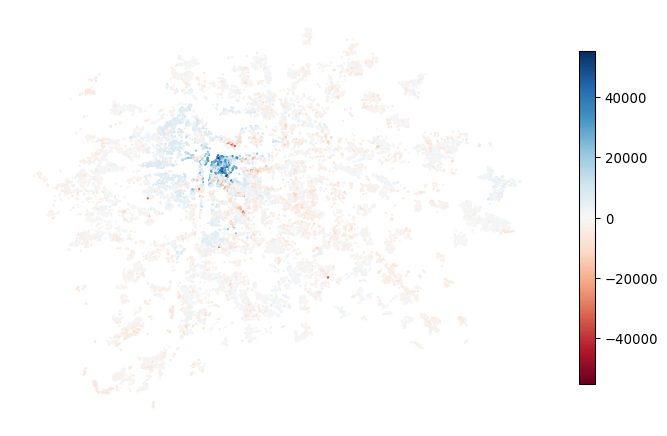

In [68]:
residuals = training_sample_price["CENA"] - predicted

maximum = np.max(np.abs(residuals))
ax = training_sample_price.plot(
    residuals,
    figsize=(9, 9),
    markersize=0.5,
    cmap="RdBu",
    legend=True,
    vmin=-maximum,
    vmax=maximum,
    legend_kwds={"shrink": 0.5},
)
ax.set_axis_off()

> **Additional reading**
>
> This material combines components from the chapters on [*Spatial
> Regression*](https://geographicdata.science/book/notebooks/11_regression.html)
> and [*Spatial Feature
> Engineering*](https://geographicdata.science/book/notebooks/12_feature_engineering.html)
> from the Geographic Data Science with Python by @rey2023geographic.

## The end

Thank you for getting this far.